In [1]:
# init
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import math
import random

import warnings
#warnings.filterwarnings("ignore")

def distance(x,y):
    
    z = x - y
    z **= 2
    return math.sqrt(z.sum())

In [2]:
# valuable constants

# testing part, probably removable
#np.random.seed(10)
#random.seed(100)

# size of area, from -x to x
area_size = 12

# amount of attractors and distractors
att_am = 3
dis_am = int(att_am * 4 / 3)

# minimal distance from attractor to attractor and from distractor to attractor
dist_att = int ((2 * area_size + 1)/ (math.sqrt(att_am)))
dist_dis = int(dist_att / 2)

# amount of points, amount of numbers after . (.0 rn)
points_am = 400
prec = 1

print (dist_att, dist_dis)

14 7


In [3]:
# generating attraction and distraction points with the rules:
# attraction points have to be far enought from each other
# distraction points have to be far enought from each other\attraction points

attract = np.empty(2).reshape(-1, 2)

flag = True
att_iter = 0

while att_iter < att_am:
    
    we_add = np.round(2 * area_size * (0.5 - np.random.rand(2)), 
                      prec).reshape(-1, 2)
    
    if flag:
        
        attract = we_add
        flag = False
        att_iter += 1
        
    else:
        
        closest_att = distance(attract[0],we_add)
        
        for i in range(att_iter):
            
            a = distance(attract[i],we_add)
            
            if a < closest_att:
                
                closest_att = a
            
        if closest_att > dist_att:
            
            attract = np.concatenate([attract, we_add])
            att_iter += 1


distract = np.empty(2).reshape(-1, 2)

flag = True
dis_iter = 0

while dis_iter < dis_am:                
    
    we_add = np.round(2 * area_size * (0.5 - np.random.rand(2)), 
                      prec).reshape(-1, 2)
    
        
    closest_att = distance(attract[0], we_add)

    for i in range(att_iter):

        a = distance(attract[i], we_add)

        if a < closest_att:

            closest_att = a
            
    if flag:
        
        closest_dis = 2 * dist_dis
        
    else:
        
        closest_dis = distance(distract[0], we_add)
        
        for i in range(dis_iter):
            
            a = distance(distract[i], we_add)
            
            if a < closest_dis:
                
                closest_dis = a

    if closest_dis > dist_dis and closest_att > dist_dis:

        if flag:
            
            distract = we_add
            flag = False
            dis_iter += 1
        
        else:
            distract = np.concatenate([distract, we_add])
            dis_iter += 1

print(attract, "\n")
print(distract)

[[-1.4 11.6]
 [-5.8 -9.7]
 [ 8.2 -2.1]] 

[[  6.8   9.2]
 [-11.    2.5]
 [  4.3  -8.3]
 [ -2.6   1.5]]


In [4]:
# generating points with the interpolary rule : random(0,1) < chance
# chance is (b/(a+b))^3
# b - distance to closest distractor, a - distance to closest attractor

points = np.empty(2).reshape(-1, 2)

flag = True
iterator = points_am

while iterator > 0:
    
    we_add = np.round(2 * area_size * (0.5 - np.random.rand(2)),
                      prec).reshape(-1,2)
    
    closest_att = distance(attract[0], we_add)
    for i in range(att_am):
        
        a = distance(attract[i], we_add)
        
        if a < closest_att:
            
            closest_att = a
        
    closest_dis = distance(distract[0], we_add)
    for i in range(dis_am):
        
        a = distance(distract[i], we_add)
        
        if a < closest_dis:
            
            closest_dis = a
            
    chance = (closest_dis / (closest_dis + closest_att)) ** 4
    
    if chance > random.random() and closest_att < closest_dis:
        
        if flag:
            
            points = we_add
            flag = False
        
        else:
            
            points = np.concatenate([points, we_add])
            
            
        iterator -= 1

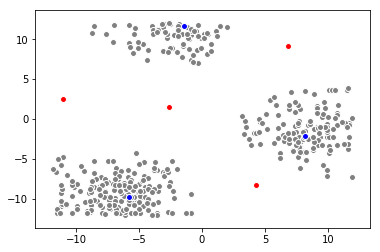

In [5]:
# showing what we built, blue dots are attraction centers
# red - distraction, gray - ordinary points

fig = plt.figure()


for i in range(points_am):
    
    plt.scatter(points[i][0],
                points[i][1], 
                color = 'gray', 
                edgecolors = 'white')
    

for i in range(att_am):
    
    plt.scatter(attract[i][0],
                attract[i][1], 
                color = 'blue', 
                edgecolors = 'white')
    
for i in range(dis_am):
    
    plt.scatter(distract[i][0],
                distract[i][1], 
                color = 'red', 
                edgecolors = 'white')

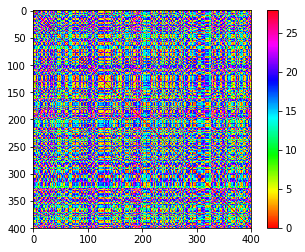

In [6]:
# generating and visualising range matrix (symmetric)
# points - all points we have

a = points.T

x = (a[0] - a[0].reshape(-1, 1)) ** 2
y = (a[1] - a[1].reshape(-1, 1)) ** 2

len = np.sqrt(x + y)

plt.imshow(len, cmap = 'hsv')
plt.colorbar(orientation = 'vertical', pad = 0.05)

In [7]:
# global k-means function
# initialising cluster centers by k-means ++ methodic
# showing only final result

# also uses some external data - array "points", "area_size" and "points_am"

def k_means(clusters_am, points_am, points):
    
    we_not_finished = True
    keep = 0 + clusters_am
    
    while we_not_finished:
    
        cluster_centers = np.zeros(2 * clusters_am).reshape(-1, 2)
        points_associations = np.zeros(points_am, dtype = 'int') - 1

        for i in range(clusters_am):

            if i == 0:

                cluster_centers[0] = points[0]
                #print(points[0])

            else:

                if i == 1:

                    range_map = (points.T[0] - 
                                 cluster_centers.T[0][i-1].reshape(-1, 1)) ** 2 + (points.T[1] - 
                                                                                  cluster_centers.T[1][i - 1].reshape(-1, 1)) ** 2

                else:
                    map_part = (points.T[0] - 
                                cluster_centers.T[0][i-1].reshape(-1, 1)) ** 2 + (points.T[1] - 
                                                                                  cluster_centers.T[1][i - 1].reshape(-1, 1)) ** 2

                    range_map = np.concatenate([range_map,map_part])

                dist = np.min(range_map, axis = 0)

                sum = np.sum(dist)
                rnd = random.uniform(0.01, 0.99) * sum

                sum1 = 0
                chos = -1

                while sum1 < rnd:

                    sum1 += dist[chos]
                    chos += 1

                cluster_centers[i] = points[chos]
                #print(points[chos])

        # no error reason b4 this point


        #print(cluster_centers)

        outer_flag = True

        while outer_flag:

            for i in range(points_am):

                ranges = np.sqrt((points[i][0] - 
                                  cluster_centers.T[0].reshape(-1, 1)) ** 2 + (points[i][1] - 
                                                                               cluster_centers.T[1].reshape(-1, 1)) ** 2)

                #print(ranges, np.argmin(ranges))

                points_associations[i] = np.argmin(ranges[:clusters_am])


            #print(np.unique(points_associations), clusters_am)

            """for i in range(points_am):

                m_range = 2 * area_size + 1

                for j in range(clusters_am):

                    curr = distance(points[i],cluster_centers[j])

                    if  curr < m_range:

                        m_range = curr
                        points_associations[i] = j """

            new_centers = np.zeros(2 * clusters_am).reshape(-1, 2)
            new_count = np.zeros(clusters_am, dtype = 'int')

            for number, point in enumerate(points):

                #print(number, point, points_associations[number])
                new_centers[points_associations[number]] += point
                new_count[points_associations[number]] += 1


            if 0 in new_count:
                
                break;

            """check_flag = True

            while check_flag:

                have_zero = False

                for j in range(clusters_am):

                    if new_count[j] == 0:

                        have_zero = True
                        break;

                if have_zero:

                    for i in range(points_am):

                        if points_associations[i] == clusters_am - 1:

                            points_associations[i] = j

                    new_centers[j] = np.copy(new_centers[clusters_am - 1])
                    new_count[j] = np.copy(new_count[clusters_am - 1])

                    clusters_am -= 1

                else:

                    check_flag = False """

            #print(new_centers, new_count)

            for j in range(clusters_am):

                new_centers[j] /= new_count[j]

            new_centers = np.round(new_centers, 1)

            #print(new_centers)

            """for j in range(clusters_am):

                curr_pos = np.zeros(2)
                num = 0

                for i in range(points_am):

                    if points_associations[i] == j:

                        curr_pos += points[i]
                        num += 1

                new_centers[j] = curr_pos / num """

            new_flag = True

            for j in range(clusters_am):

                if not np.array_equal(cluster_centers[j], new_centers[j]):

                    cluster_centers[j] = new_centers[j]
                    new_flag = False


            outer_flag = not new_flag
            
        """if clusters_am == keep:

            we_not_finished = False

        else:

            clusters_am = 0 + keep"""
        
        if outer_flag == False:
            
            we_not_finished = False


        #print(cluster_centers)    

    colors = [cm.hsv(i/(clusters_am)) for i in range(clusters_am)]

    fig = plt.figure()

    for i in range(points_am):

        plt.scatter(points[i][0],
                    points[i][1], 
                    color = colors[points_associations[i]], 
                    edgecolors = 'white')

    for i in range(clusters_am):

        plt.scatter(cluster_centers[i][0],
                    cluster_centers[i][1],
                    color = "black")

    plt.show()
        
    return cluster_centers, points_associations, clusters_am

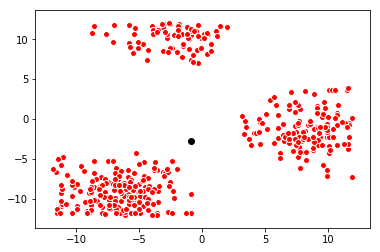

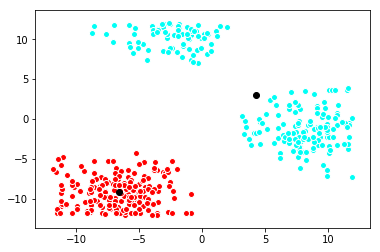

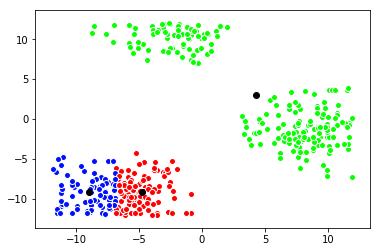

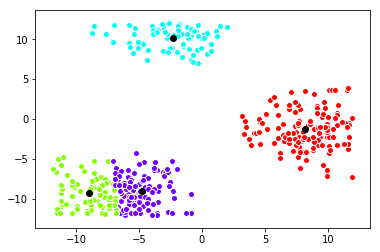

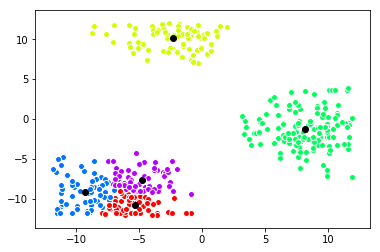

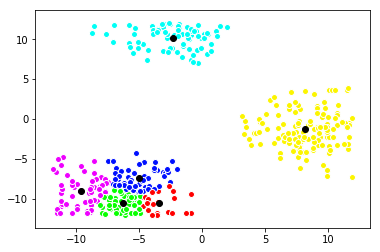

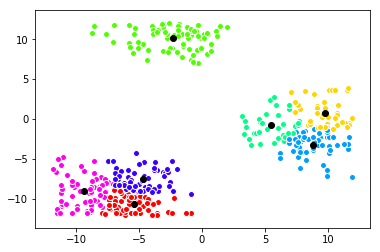

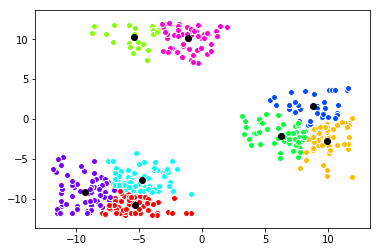

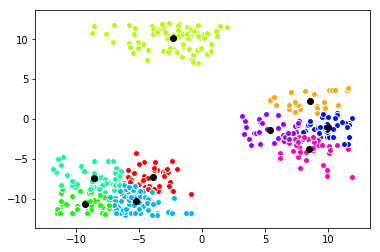

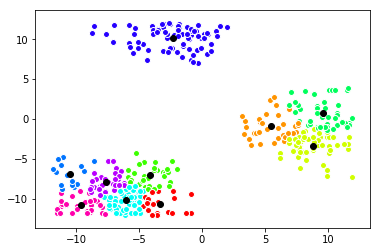

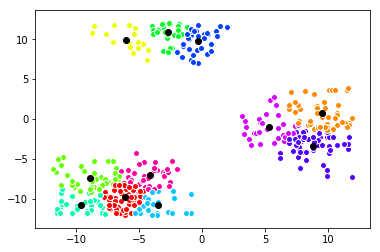

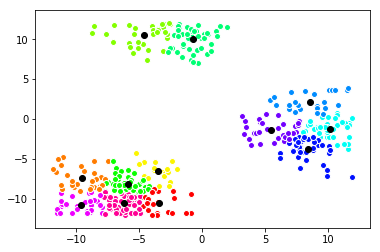

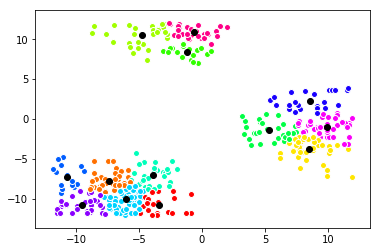

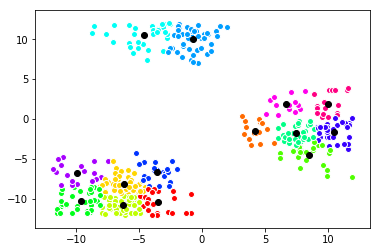

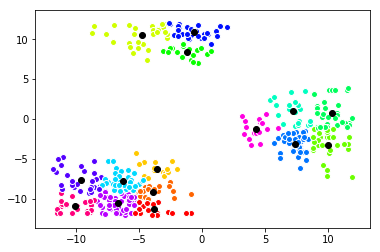

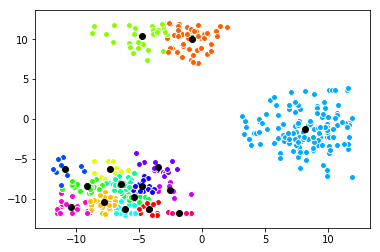

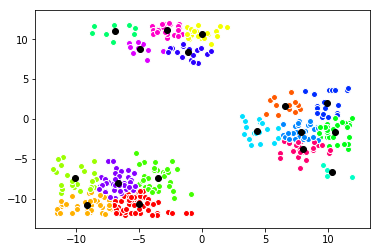

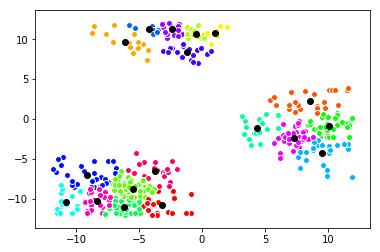

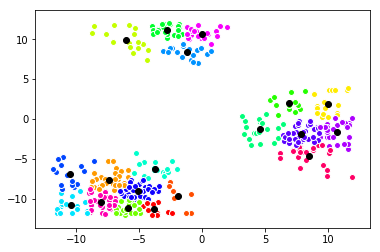

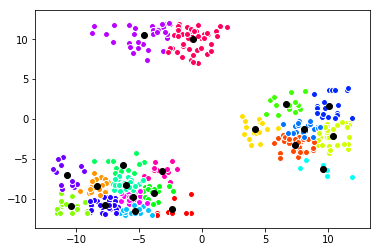

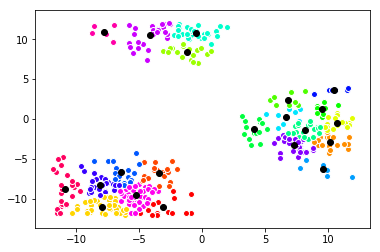

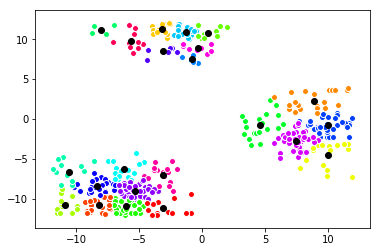

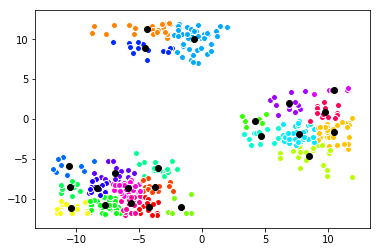

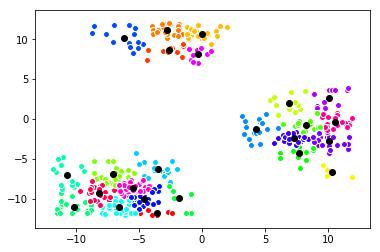

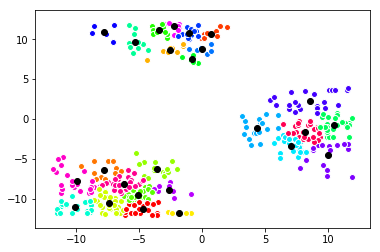

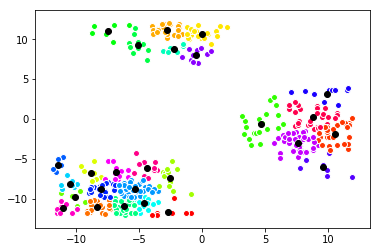

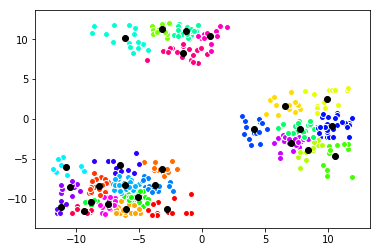

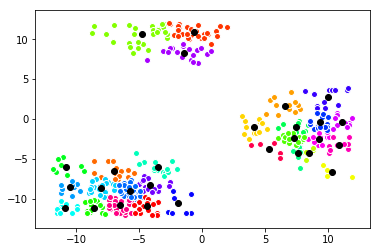

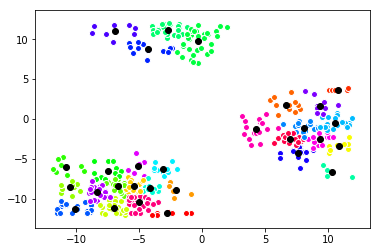

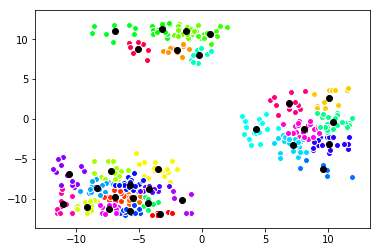

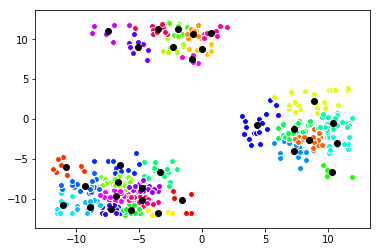

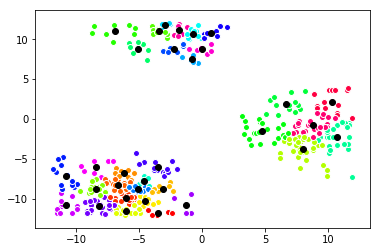

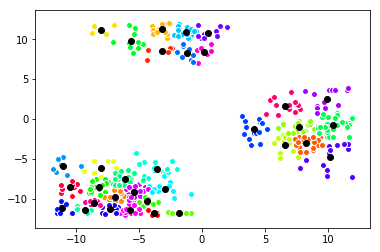

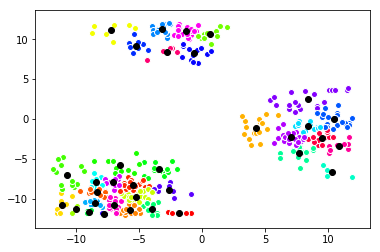

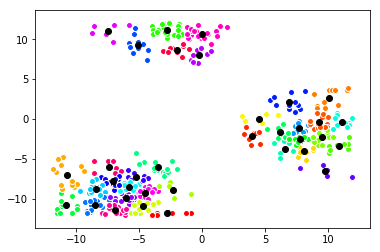

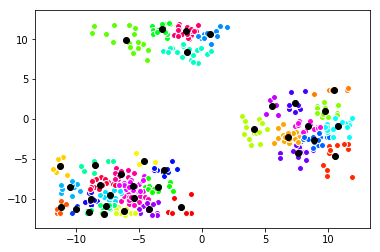

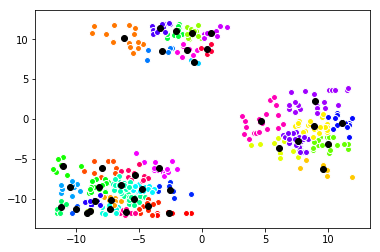

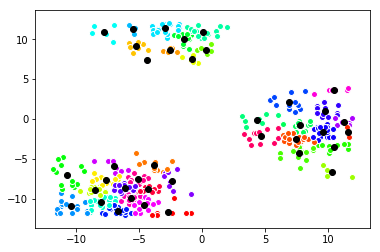

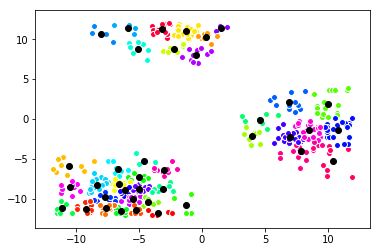

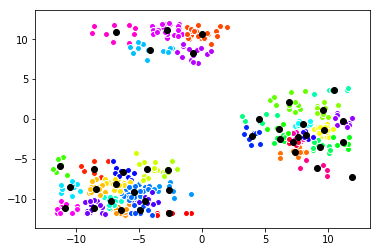

In [8]:
flag = True

clust_am = 1

saved_centers, saved_associations, a = k_means(clust_am, points_am, points)

while flag:
    
    clust_am += 1
    
    clust_centers, p_associations, remain_clusters = k_means(clust_am, points_am, points)

    if clust_am == 40:
        
        flag = False
    
    
    
    